<a href="https://colab.research.google.com/github/neilgarnet/ML-Weather-Project/blob/main/XGBoostModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded = files.upload()
#Displaying basic information about the dataset
df = pd.read_csv("/content/Weather dataset.csv")
print("Dataset Information:")
print(df.info())
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nStatistical Summary:")
print(df.describe())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           150 non-null    object 
 1   city           150 non-null    object 
 2   country        150 non-null    object 
 3   latitude       150 non-null    float64
 4   longitude      150 non-null    float64
 5   temperature    150 non-null    float64
 6   humidity       150 non-null    float64
 7   precipitation  150 non-null    float64
 8   AQI            150 non-null    int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 10.7+ KB
None

First 5 rows of the dataset:
         date      city    country  latitude  longitude  temperature  \
0  2024-06-01  New York        USA   40.7128   -74.0060     5.261208   
1  2024-06-01    London         UK   51.5074    -0.1278    16.828661   
2  2024-06-01     Tokyo      Japan   35.6895   139.6917    19.189069   
3  20

In [ ]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())



Missing Values in Each Column:
date             0
city             0
country          0
latitude         0
longitude        0
temperature      0
humidity         0
precipitation    0
AQI              0
dtype: int64


In [ ]:
# Removing duplicate rows if any
df = df.drop_duplicates()
print(df)

           date      city    country  latitude  longitude  temperature  \
0    2024-06-01  New York        USA   40.7128   -74.0060     5.261208   
1    2024-06-01    London         UK   51.5074    -0.1278    16.828661   
2    2024-06-01     Tokyo      Japan   35.6895   139.6917    19.189069   
3    2024-06-01    Sydney  Australia  -33.8688   151.2093    12.814943   
4    2024-06-01    Mumbai      India   19.0760    72.8777     9.848917   
..          ...       ...        ...       ...        ...          ...   
145  2024-06-30  New York        USA   40.7128   -74.0060    13.522181   
146  2024-06-30    London         UK   51.5074    -0.1278    10.526193   
147  2024-06-30     Tokyo      Japan   35.6895   139.6917     1.573264   
148  2024-06-30    Sydney  Australia  -33.8688   151.2093    17.722635   
149  2024-06-30    Mumbai      India   19.0760    72.8777    -0.910156   

     humidity  precipitation  AQI  
0       43.13       0.288007  152  
1       63.49       0.849684  142  
2  

In [ ]:
# Convert 'date' column to datetime format and extract additional temporal features
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
print(df)

          date      city    country  latitude  longitude  temperature  \
0   2024-06-01  New York        USA   40.7128   -74.0060     5.261208   
1   2024-06-01    London         UK   51.5074    -0.1278    16.828661   
2   2024-06-01     Tokyo      Japan   35.6895   139.6917    19.189069   
3   2024-06-01    Sydney  Australia  -33.8688   151.2093    12.814943   
4   2024-06-01    Mumbai      India   19.0760    72.8777     9.848917   
..         ...       ...        ...       ...        ...          ...   
145 2024-06-30  New York        USA   40.7128   -74.0060    13.522181   
146 2024-06-30    London         UK   51.5074    -0.1278    10.526193   
147 2024-06-30     Tokyo      Japan   35.6895   139.6917     1.573264   
148 2024-06-30    Sydney  Australia  -33.8688   151.2093    17.722635   
149 2024-06-30    Mumbai      India   19.0760    72.8777    -0.910156   

     humidity  precipitation  AQI  month  day  
0       43.13       0.288007  152      6    1  
1       63.49       0.84968

In [ ]:
# Creating new features based on domain insights:
# - Interaction between temperature and humidity
# - Interaction between temperature and precipitation
df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
df['temp_precipitation_interaction'] = df['temperature'] * df['precipitation']

In [ ]:
#Outlier Detection & Treatment using IQR
def cap_outliers(col):
    """
    Caps the outliers in a numerical column using the IQR method.
    Outliers below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR) are replaced with these threshold values.
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return col.clip(lower_bound, upper_bound)

# Applying outlier capping on 'temperature' and 'precipitation'
df['temperature'] = cap_outliers(df['temperature'])
df['precipitation'] = cap_outliers(df['precipitation'])
print(df)

          date      city    country  latitude  longitude  temperature  \
0   2024-06-01  New York        USA   40.7128   -74.0060     5.261208   
1   2024-06-01    London         UK   51.5074    -0.1278    16.828661   
2   2024-06-01     Tokyo      Japan   35.6895   139.6917    19.189069   
3   2024-06-01    Sydney  Australia  -33.8688   151.2093    12.814943   
4   2024-06-01    Mumbai      India   19.0760    72.8777     9.848917   
..         ...       ...        ...       ...        ...          ...   
145 2024-06-30  New York        USA   40.7128   -74.0060    13.522181   
146 2024-06-30    London         UK   51.5074    -0.1278    10.526193   
147 2024-06-30     Tokyo      Japan   35.6895   139.6917     1.573264   
148 2024-06-30    Sydney  Australia  -33.8688   151.2093    17.722635   
149 2024-06-30    Mumbai      India   19.0760    72.8777    -0.910156   

     humidity  precipitation  AQI  month  day  temp_humidity_interaction  \
0       43.13       0.288007  152      6    1  

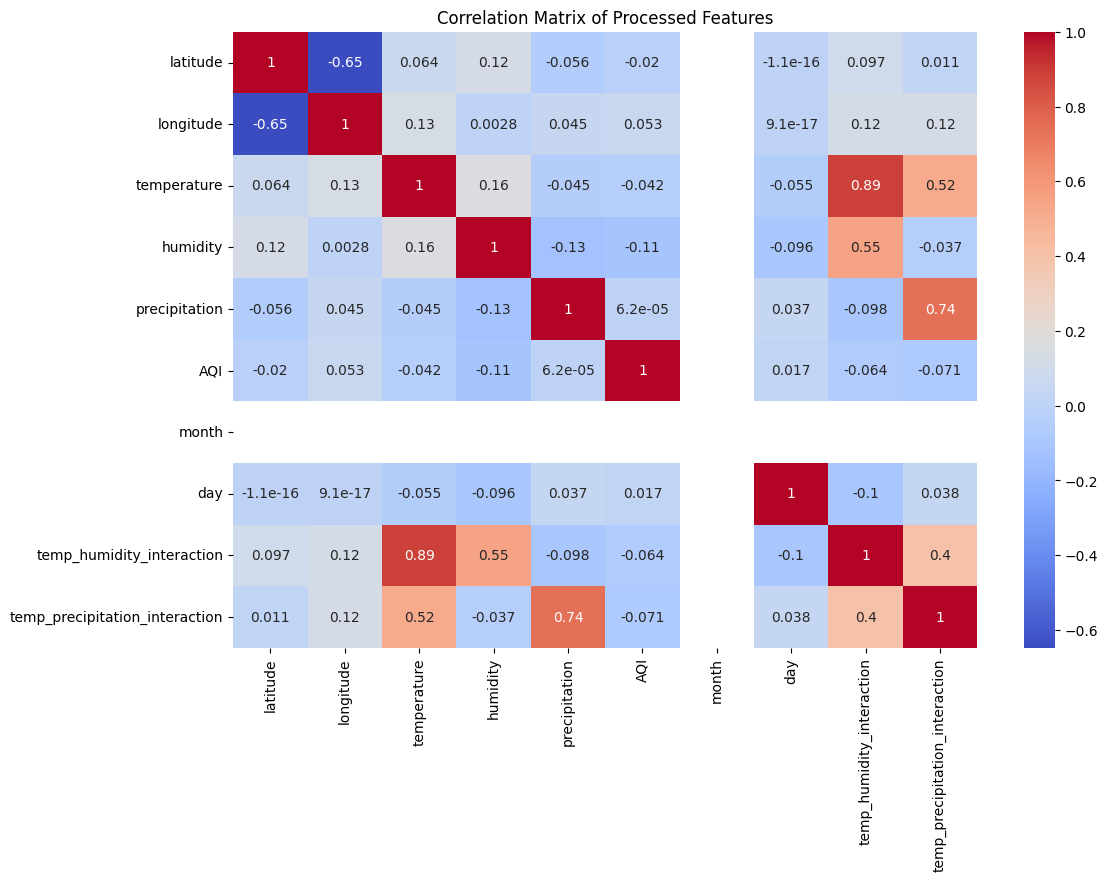

In [ ]:
# Feature Selection Insight (Correlation Matrix)
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
# Plot the correlation matrix to understand relationships between features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Processed Features")
plt.show()



In [ ]:
# Final Processed Data Overview
print(df)

          date      city    country  latitude  longitude  temperature  \
0   2024-06-01  New York        USA   40.7128   -74.0060     5.261208   
1   2024-06-01    London         UK   51.5074    -0.1278    16.828661   
2   2024-06-01     Tokyo      Japan   35.6895   139.6917    19.189069   
3   2024-06-01    Sydney  Australia  -33.8688   151.2093    12.814943   
4   2024-06-01    Mumbai      India   19.0760    72.8777     9.848917   
..         ...       ...        ...       ...        ...          ...   
145 2024-06-30  New York        USA   40.7128   -74.0060    13.522181   
146 2024-06-30    London         UK   51.5074    -0.1278    10.526193   
147 2024-06-30     Tokyo      Japan   35.6895   139.6917     1.573264   
148 2024-06-30    Sydney  Australia  -33.8688   151.2093    17.722635   
149 2024-06-30    Mumbai      India   19.0760    72.8777    -0.910156   

     humidity  precipitation  AQI  month  day  temp_humidity_interaction  \
0       43.13       0.288007  152      6    1  

In [ ]:
# Import necessary libraries
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# One-hot encode 'city' and 'country'
df = pd.get_dummies(df, columns=['city', 'country'], drop_first=True)
print(df)

          date  latitude  longitude  temperature  humidity  precipitation  \
0   2024-06-01   40.7128   -74.0060     5.261208     43.13       0.288007   
1   2024-06-01   51.5074    -0.1278    16.828661     63.49       0.849684   
2   2024-06-01   35.6895   139.6917    19.189069     54.23       1.560259   
3   2024-06-01  -33.8688   151.2093    12.814943     33.89       0.601335   
4   2024-06-01   19.0760    72.8777     9.848917     45.23       0.658809   
..         ...       ...        ...          ...       ...            ...   
145 2024-06-30   40.7128   -74.0060    13.522181     83.20       0.097998   
146 2024-06-30   51.5074    -0.1278    10.526193     31.66       0.141194   
147 2024-06-30   35.6895   139.6917     1.573264     64.73       0.179365   
148 2024-06-30  -33.8688   151.2093    17.722635     56.31       0.320157   
149 2024-06-30   19.0760    72.8777    -0.910156     70.32       0.077903   

     AQI  month  day  temp_humidity_interaction  \
0    152      6    1    

In [ ]:
# 1. Data Preparation

# Define the target variable and features
target = 'temperature'  # Change this to 'AQI' or any other target variable as needed

# Select numeric features for the model
X = df.drop(columns=[target, 'date'])  # Drop target and non-numeric/non-useful columns
y = df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 2. Model Initialization & Training



# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Train the model on the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 3. Predictions & Evaluation

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR² Score: {r2:.2f}")


Model Performance:
RMSE: 2.04
MAE: 1.49
R² Score: 0.91


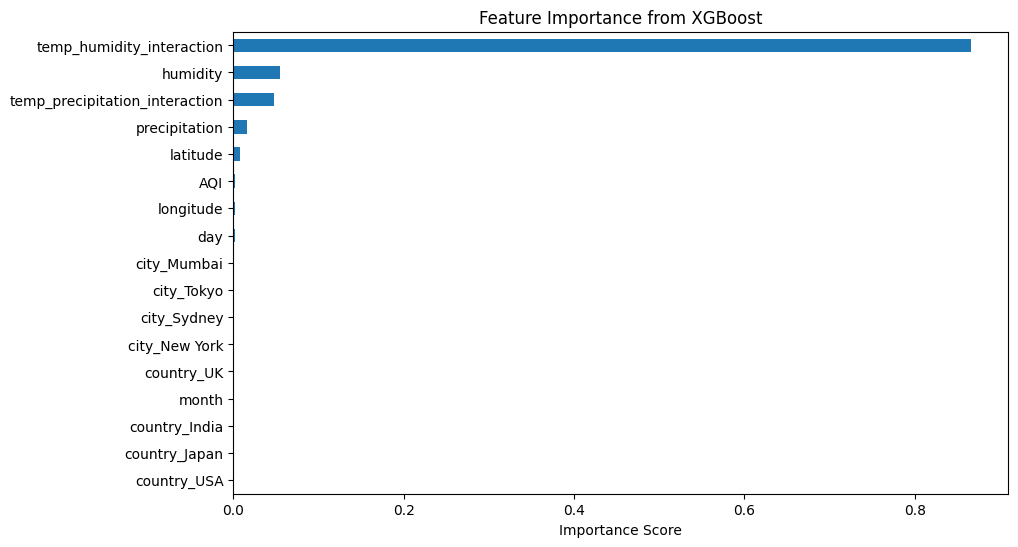

In [ ]:
# 4. Feature Importance Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance Score")
plt.show()